# Wang-Roychowdhury Oscillator Ising Machines

p-bits as a concept are generally for exotic stochastic nanodevices designed to do nothing but to provide the precise probabilities needed to realise Ising machines. But as amateurs, we are at best stuck on fairly traditional process nodes using CMOS technologies.

So, are there any more pragmatic ways that we can construct Ising machines using these more traditional manufacturing techniques? It turns out that the answer to these questions is actually and emphatic yes, and we may have been sitting on how to construct such machines since the 1970's.

### Kuramoto's Model

Given $N$ coupled oscillators, with a coupling constant $K$, the change in phase of the $i^{\text{th}}$ node with phase $\theta_i$ and frequency $\omega_i$ is given by the following equation:

$$\dfrac{d \theta_i}{dt} = \omega_i + \dfrac{K}{N}\sum_{j=1}^N \sin(\theta_j - \theta_i)$$

The best way to think about this equation is to imagine a group of $N$ metronomes on a wobbly table - the wobblier, the bigger the $K$. And slowly as the average momentum of the pendulums swing the table back and forth, the majority will slowly nudge all of the other pendula to a synchronized average.

The story for Kuramoto's model doesn't end here however, as we can introduce the inhomogeneous Kuramoto's model (the choice of $J$ is deliberate...):

$$\dfrac{d \theta_i}{dt} = -K \sum_{j=1}^N J_{ij}\sin(\theta_i - \theta_j)$$

Okay, this is really cool and all - but what does this have anything to do with p-bit Ising machines. Well, an important result is that this differential equation has a global Lyapunov function (that the above system always minimizes):

$$E(\Theta)= -K\sum_{i,j} J_{ij} \cos(\theta_i-\theta_j)$$

Where $\Theta$ is the entire system of $\theta_i$. Now if we map phase $\theta_i = 0$ to state $s_i=+1$ as we've seen in previous chapters, and $\theta_i=\pi$ to state $s_i=-1$, we get the statement:

$$E(\mathbf{\theta(t)})= -K\sum_{i,j} J_{ij} \cos(\theta_i-\theta_j) = -K\sum_{i,j} J_{ij} s_i s_j$$

Proving this involves a couple trig identities, but you can see that up to the choice in $K$ this is exactly the Ising Hamiltonian!!

### Designing Circuits

Well... a part of it anyway, it's missing the important linear term of the Ising Hamiltonian:

$$\sum_{i} h_i s_i$$

When I first saw this, my heart sank a little, this is a pretty important piece of all the p-logic that I care about. But I found a simple linear algebra trick that lets me realise the same circuit with only a minor trade off the ordinary p-bit way of doing things:

Generally, we can think of the Ising Hamiltonian as being the Quadratic Programming problem for the Ising Machine which we can rearrange:

$$\mathbf{s}^\intercal \mathbf{J} \mathbf{s} + \mathbf{h}^\intercal \mathbf{s} = 
[\mathbf{s}:1]^\intercal\begin{bmatrix}
\mathbf{J} & \mathbf{h}/2 \\
\mathbf{h}^\intercal/2 & 0 
\end{bmatrix}[\mathbf{s}:1] = \mathbf{J}'$$

Where I've made bigger matrix by sticking together $\mathbf{J}$ and the vector $\mathbf{h}$ and its transpose and I've just tacked a 1 onto the end of the state vector $\mathbf{s}$.

The main point of this identity, is that the ordinary biases can be just wrapped into a slightly bigger matrix bias-free. The minima will still all be the same, as indeed, the problems are secretly the same - so we get all of our p-logic for free.

Let's try out the identity on the personal favorite, the p-AND gate:

$$\mathbf{J} = \begin{bmatrix}0 & -1 & 2 \\ -1 & 0 & 2 \\ 2 & 2 & 0\end{bmatrix},\qquad \mathbf{h}=\begin{bmatrix}1 \\ 1 \\ -2 \end{bmatrix}$$

So this gives us the matrix:

$$\mathbf{J}' = \begin{bmatrix}0 & -2 & 4 & 1 \\ -2 & 0 & 4 & 1 \\ 4 & 4 & 0 & -2 \\ 1 & 1 & -2 & 0\end{bmatrix}$$

I've multiplied it by two, as these really just represent multiples of the minimal quantity given by the quadratic form over $\mathbf{J}'$.

Now that we have the general idea, let's plug this $\mathbf{J}'$ into our heterogeneous Kuramoto model and see what happens in the phase space of our AND oscillator.

#### REMEMBER: WHEN LOOKING AT THE BELOW PLOT $\pi$ is OFF and $0$ is ON

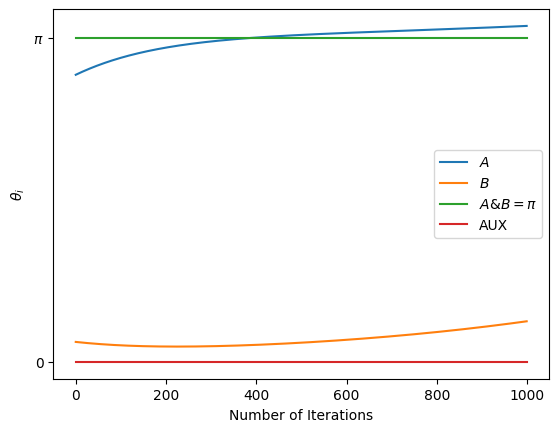

In [224]:
import numpy as np

J = np.array([
    [0,-2,4,1],
    [-2,0,4,1],
    [4,4,0,-2],
    [1,1,-2,0]
])

# Utility function to map from ordinary binary to phase weirdness
def bin2phase(inp:int) -> float:

    if inp != 0 and inp != 1:
        raise ValueError("Only 0/1 allowed!")

    return (1-inp)*np.pi

K = 0.1
dt = 1e-2
theta = np.random.uniform(0,np.pi,4)
theta[2] = bin2phase(0)
theta[3] = bin2phase(1) # this never changes

def kuramoto_step(J,theta,K,dt):

    dtheta = np.sum(-K * J * np.sin(np.subtract.outer(theta,theta)) * dt, axis=1)
    dtheta[2] = 0
    dtheta[3] = 0

    return theta + dtheta

cache = []

for i in range(1000):

    theta = kuramoto_step(J,theta,K,dt)
    cache.append(list(theta))

import matplotlib.pyplot as plt

cache = np.array(cache)
for i, label in enumerate([r"$A$", r"$B$", r"$A&B=\pi$", "AUX"]):
    plt.plot(cache[:, i], label=label)

plt.yticks([0, np.pi], ['0', r'$\pi$'])
plt.xlabel("Number of Iterations")  # X-axis label
plt.ylabel(r'$\theta_i$')  # Y-axis label with theta symbol
plt.legend()
plt.show()